# Explainable emotion recognition

**Outline of the project :**
- Implement simple Facial Expression Recognition (FER) on FER2013 and AffectNet datasets
- Implement GradCAM
- Extend this to video (see ressources : In search of a robust facial expressions recognition model: A large-scale visual cross-corpus study) for datasets of dynamic emotion recognition

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

In [2]:
train_dir = "data/fer2013/train" 
test_dir = "data/fer2013/test" 
val_dir = "data/fer2013/val" 

class_to_idx = {"Angry": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Sad": 4, "Surprise": 5, "Neutral": 6}
idx_to_class = {v: k for k, v in class_to_idx.items()}

n_classes = 7

mean_ds = torch.Tensor([0.1607, 0.2938, 0.5147])
std_ds = torch.Tensor([0.8407, 0.8595, 0.8557])


## Load the model

In [18]:
from torchvision.models import resnet50, ResNet50_Weights
from torch import nn

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
preprocess = weights.transforms()

model.fc = nn.Linear(model.fc.in_features, n_classes)
print(model)

model = model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Visualisation

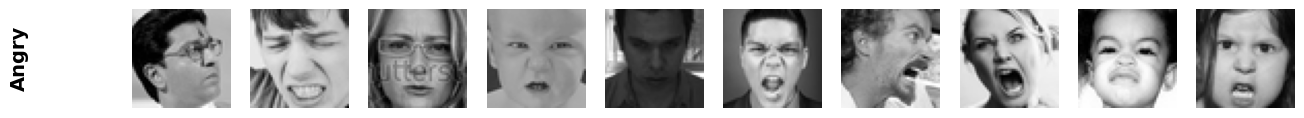

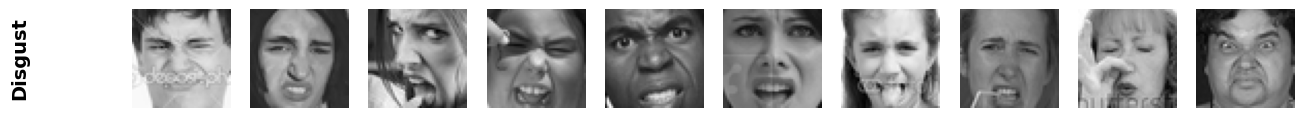

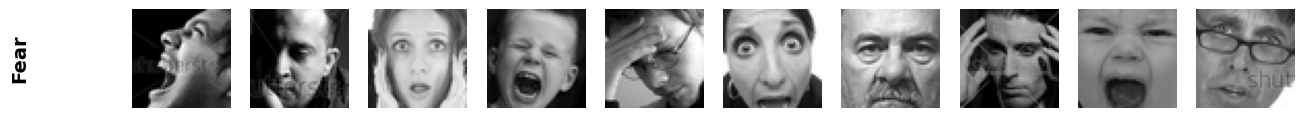

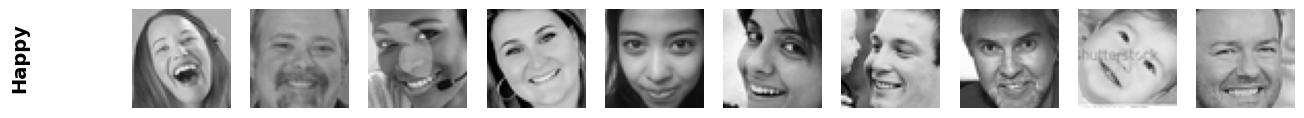

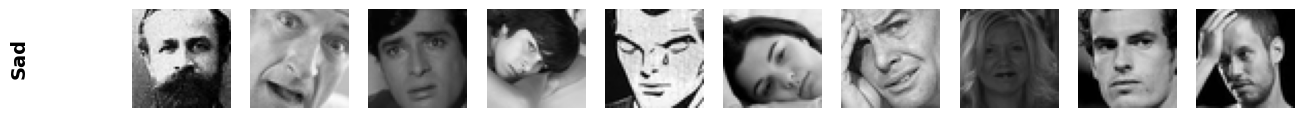

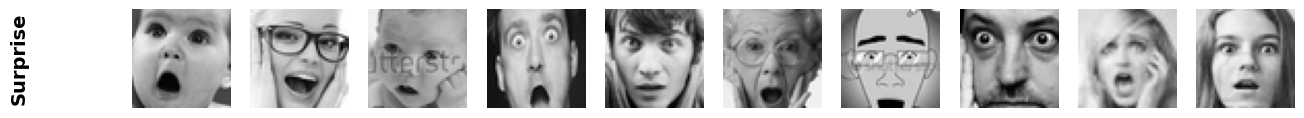

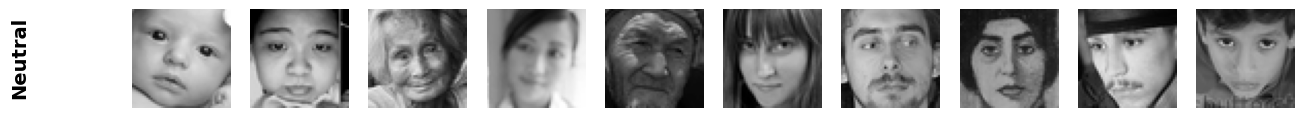

In [4]:
N = 10

visu_transform = transforms.Compose([])

visuset = datasets.ImageFolder(root=test_dir, transform=visu_transform)
visuloader = DataLoader(visuset, batch_size=None, shuffle=True)

# Find N examples per class
examples = {i: [] for i in range(n_classes)}
for img, label in visuloader:
    if len(examples[label]) < N:
        examples[label].append(img)
    if all(len(examples[i]) == N for i in range(n_classes)):
        break

# Plot examples
for i in range(n_classes):
    fig = plt.figure(figsize=(15, 2))
    for j in range(N):
        plt.subplot(1, N, j+1)
        plt.imshow(examples[i][j])
        plt.axis("off")
    fig.text(0.05, 0.5, idx_to_class[i], va="center", ha="center", fontsize=14, fontweight="bold", rotation=90)

    plt.show()


## Finetuning

In [19]:
# Training data

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean_ds, std=std_ds),
])


train_transform = transforms.Compose([
    preprocess,
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
])

val_transform = preprocess

trainset = datasets.ImageFolder(root=train_dir, transform=train_transform)
valset = datasets.ImageFolder(root=val_dir, transform=val_transform)

In [21]:
# Training loop

def train(n_epochs, model, trainloader, valloader, optimizer, criterion):

    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(n_epochs):

        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{n_epochs} - Training"):
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(trainloader))

        model.eval()
        val_loss, accuracy = 0.0, 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(valloader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation"):
                outputs = model(inputs.to(device))
                loss = criterion(outputs, labels.to(device))
                val_loss += loss.item()
                accuracy += (outputs.argmax(dim=1) == labels.to(device)).float().mean().item()
        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(accuracy / len(valloader))

        print(f">> Training loss: {train_losses[-1]:.4f} - Validation loss: {val_losses[-1]:.4f} - Validation accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, val_accuracies

def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_accuracy(val_accuracies):
    plt.plot(val_accuracies, label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

Epoch 1/10 - Validation: 100%|██████████| 57/57 [00:12<00:00,  4.69it/s]


>> Training loss: 1.3526 - Validation loss: 1.2784 - Validation accuracy: 0.5106


Epoch 2/10 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.89it/s]


>> Training loss: 1.1547 - Validation loss: 1.1690 - Validation accuracy: 0.5527


Epoch 3/10 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.81it/s]


>> Training loss: 1.0868 - Validation loss: 1.1481 - Validation accuracy: 0.5614


Epoch 4/10 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.92it/s]


>> Training loss: 1.0484 - Validation loss: 1.0668 - Validation accuracy: 0.6096


Epoch 5/10 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.95it/s]


>> Training loss: 1.0076 - Validation loss: 1.0604 - Validation accuracy: 0.6157


Epoch 6/10 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.94it/s]


>> Training loss: 0.9737 - Validation loss: 1.0530 - Validation accuracy: 0.6081


Epoch 7/10 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.79it/s]


>> Training loss: 0.9505 - Validation loss: 1.0420 - Validation accuracy: 0.6140


Epoch 8/10 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.91it/s]


>> Training loss: 0.9254 - Validation loss: 1.0062 - Validation accuracy: 0.6190


Epoch 9/10 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.92it/s]


>> Training loss: 0.8999 - Validation loss: 1.0307 - Validation accuracy: 0.5990


Epoch 10/10 - Validation: 100%|██████████| 57/57 [00:09<00:00,  5.86it/s]


>> Training loss: 0.8757 - Validation loss: 0.9898 - Validation accuracy: 0.6305


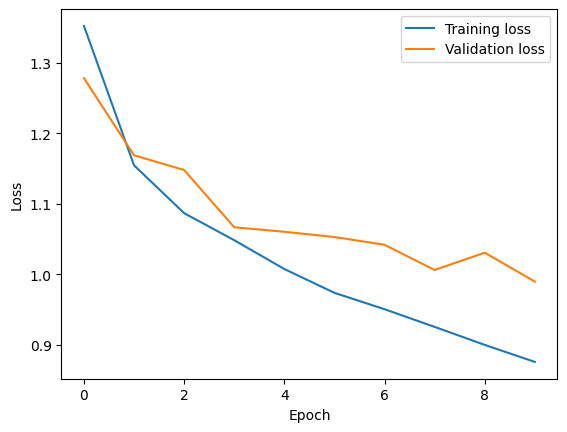

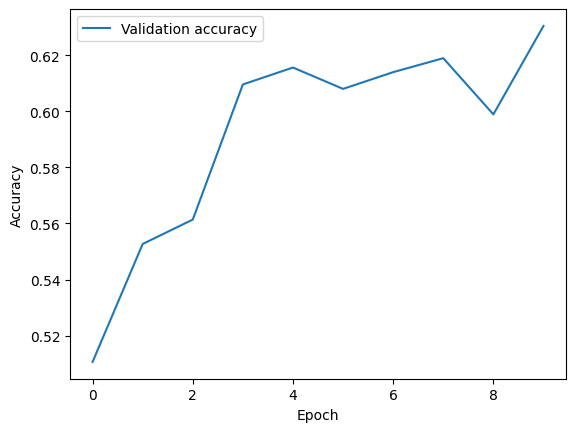

In [22]:
# Training

n_epochs = 10
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

train_losses, val_losses, val_accuracies = train(n_epochs, model, trainloader, valloader, optimizer, criterion)
plot_loss(train_losses, val_losses)
plot_accuracy(val_accuracies)

In [69]:
# save model

name_save = f"resnet50_10epochs_0.63acc"
torch.save(model.state_dict(), f"weights/{name_save}.pth")

## CAM

In [65]:
from torchcam.methods import SmoothGradCAMpp

model.eval()

# CAM initialisaiton
cam_layer = "layer4.1.conv2"
cam_extractor = SmoothGradCAMpp(model, target_layer=cam_layer)

# input - output
img, label = visuset[np.random.choice(len(visuset))]
output = model(preprocess(img).unsqueeze(0).to(device))

# CAM computation
activation_maps = cam_extractor(class_idx=output.squeeze(0).argmax().item(), scores=output)


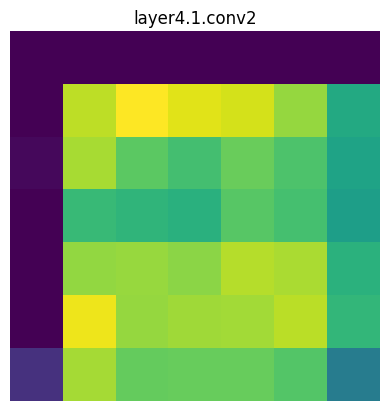

In [66]:
# visualization_extractor

for name, map in zip(cam_extractor.target_names, activation_maps):
  plt.imshow(map.squeeze(0).cpu().numpy()); plt.axis('off'); plt.title(name); plt.show()
     

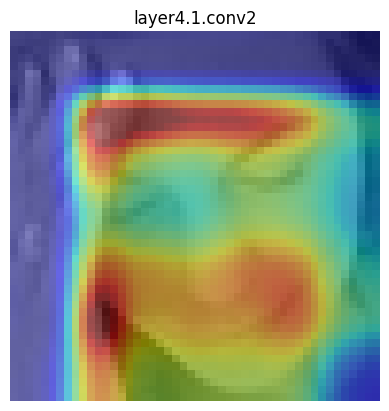

In [67]:
# Overlayed on the image

from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

for name, map in zip(cam_extractor.target_names, activation_maps):
  result = overlay_mask(img, to_pil_image(map.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()